# **PREDICTING LYFT'S REVENUES**

**Using a datset derived from a simulation of Lyft's driver revenues database, 
we perform an analysis using linear regression to see if we can predict driver revenues
based on the given features.**

## Import Libraries

In [1105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Obtain Data & Get Overview

In [1106]:
df = pd.read_csv("Lyft.csv")

**First thing we need to do is check out what types of data we're dealing with**

In [1107]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184007 entries, 0 to 184006
Data columns (total 25 columns):
id                184007 non-null int64
driver_id         184007 non-null object
ride_id           184007 non-null object
requested         184007 non-null object
accepted          184007 non-null object
arrived           184007 non-null object
picked_up         184007 non-null object
dropped_off       184007 non-null object
dis_meters        184007 non-null int64
dis_miles         184007 non-null float64
dur_seconds       184007 non-null int64
dur_minutes       184007 non-null float64
prime_time        184007 non-null float64
base_fare         184007 non-null int64
cp_mile           184007 non-null float64
cp_min            184007 non-null float64
service_fee       184007 non-null float64
min_fare          184007 non-null int64
max_fare          184007 non-null int64
fare_subtotal     184007 non-null float64
prime_time_fee    184007 non-null float64
total_fare        184007 n

In [1108]:
df.head()

,id,driver_id,ride_id,requested,accepted,arrived,picked_up,dropped_off,dis_meters,dis_miles,...,cp_min,service_fee,min_fare,max_fare,fare_subtotal,prime_time_fee,total_fare,actual_total,lyft_cut,driver_cut
0,1,d967f5296732fa55266b5f1314e7447b,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:00,2016-06-13 09:39:00,2016-06-13 09:44:00,2016-06-13 09:44:00,2016-06-13 10:03:00,3698,2.30,...,0.22,1.75,5,400,8.72,0.00,10.47,10.47,2.09,8.38
1,2,0656192a402808805282e60761bda088,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:00,2016-05-14 05:23:00,2016-05-14 05:26:00,2016-05-14 05:26:00,2016-05-14 05:34:00,3016,1.87,...,0.22,1.75,5,400,5.91,1.48,7.91,7.91,1.58,6.33
2,3,c468a648519cd42da75e6aa9dadf733e,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:00,2016-05-16 15:43:00,2016-05-16 15:47:00,2016-05-16 15:47:00,2016-05-16 15:54:00,4084,2.54,...,0.22,1.75,5,400,6.41,4.81,8.91,8.91,1.78,7.13
3,4,689bdf87fb2de49f98bf4946cfaa5068,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:00,2016-05-11 19:29:00,2016-05-11 19:35:00,2016-05-11 19:35:00,2016-05-11 19:40:00,1646,1.02,...,0.22,1.75,5,400,4.39,3.30,6.89,6.89,1.38,5.51
4,5,eece82fe623b4bb335a9b9e20eb0ca54,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:44:00,2016-05-31 15:45:00,2016-05-31 15:46:00,2016-05-31 15:46:00,2016-05-31 15:59:00,3357,2.09,...,0.22,1.75,5,400,7.27,0.00,9.02,9.02,1.80,7.22


**As we have timestamp data in our dataframe, we need to make sure that we convert their datatypes to
a DATETIME object. This is probably one of the most important things to be done in getting an overview
of a dataset. All sorts of issues can present themselves if this isn't take care of up front!**

In [1109]:
for col in df:
    if col in "requested,accepted,arrived,picked_up,dropped_off":
        df[col] = pd.to_datetime(df[col])
    elif df[col].dtype == "int":
        df[col] = df[col].astype('float')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184007 entries, 0 to 184006
Data columns (total 25 columns):
id                184007 non-null float64
driver_id         184007 non-null object
ride_id           184007 non-null object
requested         184007 non-null datetime64[ns]
accepted          184007 non-null datetime64[ns]
arrived           184007 non-null datetime64[ns]
picked_up         184007 non-null datetime64[ns]
dropped_off       184007 non-null datetime64[ns]
dis_meters        184007 non-null float64
dis_miles         184007 non-null float64
dur_seconds       184007 non-null float64
dur_minutes       184007 non-null float64
prime_time        184007 non-null float64
base_fare         184007 non-null float64
cp_mile           184007 non-null float64
cp_min            184007 non-null float64
service_fee       184007 non-null float64
min_fare          184007 non-null float64
max_fare          184007 non-null float64
fare_subtotal     184007 non-null float64
prime_time_fee  

**Next, we check to see if any columns have NULL values**

In [1110]:
pd.isnull(df).values.any()

False

## Feature Engineering & Selection

**Now, since we really can't do much with DATETIME objects by themselves, we're really much more interested in the difference between the timestamps. So let's engineer four new features that reflect the difference between when a driver:**
- **received the ride request and accepted the request**
- **accepted and arrived at the passenger's location**
- **arrived and picked up the passenger**
- **picked up and dropped off the passenger at their destination**

In [1111]:
df['diff_req_acc'] = (df['accepted'] - df['requested']).astype('timedelta64[s]')
df['diff_acc_arr'] = (df['arrived'] - df['accepted']).astype('timedelta64[s]')
df['diff_arr_pick'] = (df['picked_up'] - df['arrived']).astype('timedelta64[s]')
df['diff_pick_drop'] = (df['dropped_off'] - df['picked_up']).astype('timedelta64[s]')

**Next, we'll remove the timestamps and all of the superflous features based on our domain knowledge**

In [1112]:
df2= df[['diff_req_acc','diff_acc_arr','diff_arr_pick','diff_pick_drop','dis_miles','dur_seconds','prime_time','actual_total']].copy()

In [1113]:
df2.head()

,diff_req_acc,diff_acc_arr,diff_arr_pick,diff_pick_drop,dis_miles,dur_seconds,prime_time,actual_total
0,0.0,300.0,0.0,1140.0,2.30,1112.0,0.00,10.47
1,0.0,180.0,0.0,480.0,1.87,479.0,0.25,7.91
2,0.0,240.0,0.0,420.0,2.54,406.0,0.75,8.91
3,0.0,360.0,0.0,300.0,1.02,332.0,0.75,6.89
4,60.0,60.0,0.0,780.0,2.09,783.0,0.00,9.02


## Multicollinearity Check!

**If we're going to perform linear regression, we want to see which features are 
independent predictors of our target variable. What we don't want is for these features
getting too busy predicting each other that they can't predict the target! So we check
for high levels of inter-correlation between independent features...**

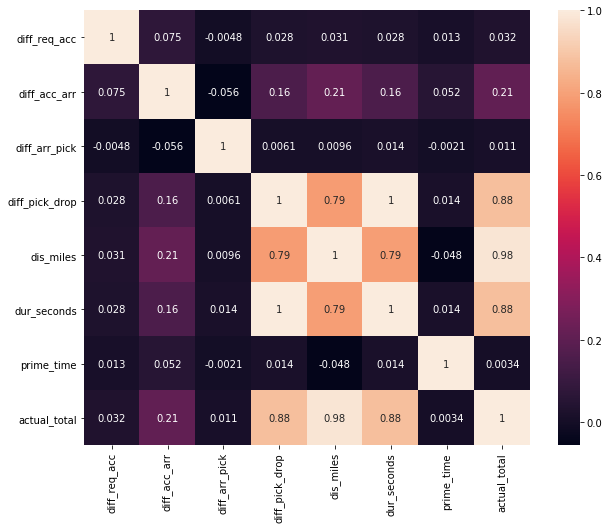

In [1114]:
plt.figure(figsize=(10, 8))
sns.heatmap(df2.corr(),annot=True)

In [1115]:
df3= df2[['diff_req_acc','diff_acc_arr','diff_arr_pick','diff_pick_drop','prime_time','actual_total']].copy()

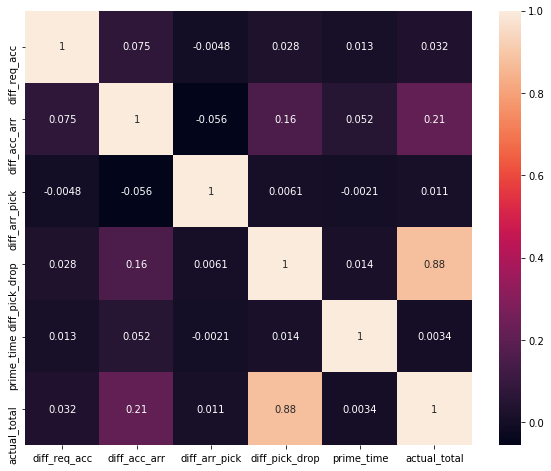

In [1116]:
plt.figure(figsize=(10, 8))
sns.heatmap(df3.corr(),annot=True)

## Data Distribution

In [1117]:
df3.describe()

,diff_req_acc,diff_acc_arr,diff_arr_pick,diff_pick_drop,prime_time,actual_total
count,184007.000000,184007.000000,184007.000000,184007.000000,184007.000000,184007.000000
mean,11.536192,243.603450,6.697897,859.990326,0.173958,12.037122
std,41.131042,182.226124,19.248728,573.083192,0.308286,8.051167
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,0.000000,120.000000,0.000000,480.000000,0.000000,7.600000
50%,0.000000,180.000000,0.000000,720.000000,0.000000,9.600000
75%,0.000000,300.000000,0.000000,1080.000000,0.250000,13.030000
max,5040.000000,3660.000000,840.000000,28200.000000,5.000000,400.000000


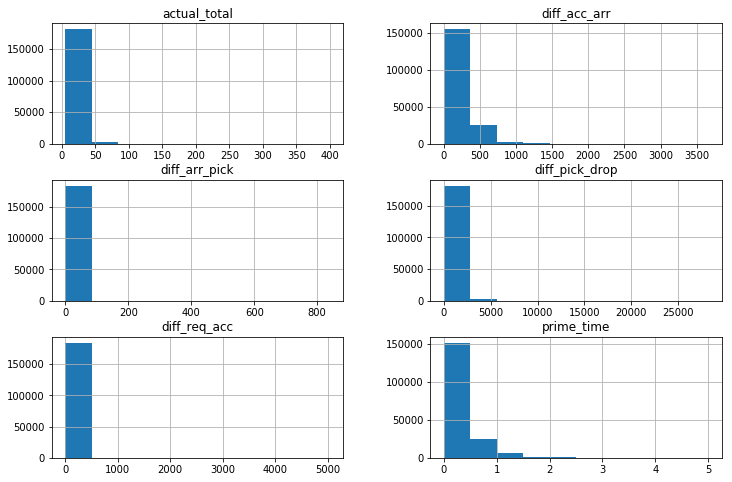

In [1118]:
df3.hist(figsize = (12,8));

## Removing Outliers

In [1119]:
len(df3[df3['actual_total'] > 50]) / len(df3) # less than 1%
df3.drop(df3[df3['actual_total'] > 50].index, inplace=True)

In [1120]:
len(df3[df3['diff_acc_arr'] > 1000]) / len(df3) # less than 1%
df3.drop(df3[df3['diff_acc_arr'] > 1000].index, inplace=True)

In [1121]:
len(df3[df3['diff_arr_pick'] > 80]) / len(df3) # less than 1%
df3.drop(df3[df3['diff_arr_pick'] > 80].index, inplace=True)

In [1122]:
len(df3[df3['diff_pick_drop'] > 2600]) / len(df3) # less than 1%
df3.drop(df3[df3['diff_pick_drop'] > 2600].index, inplace=True)

In [1123]:
len(df3[df3['diff_req_acc'] > 120]) / len(df3) # less than 1%
df3.drop(df3[df3['diff_req_acc'] > 120].index, inplace=True)

In [1124]:
len(df3[df3['prime_time'] > 1.5]) / len(df3) # less than 1%
df3.drop(df3[df3['prime_time'] > 1.5].index, inplace=True)

## Log Transforming
**Let's see if we can coerce a normal distribution**

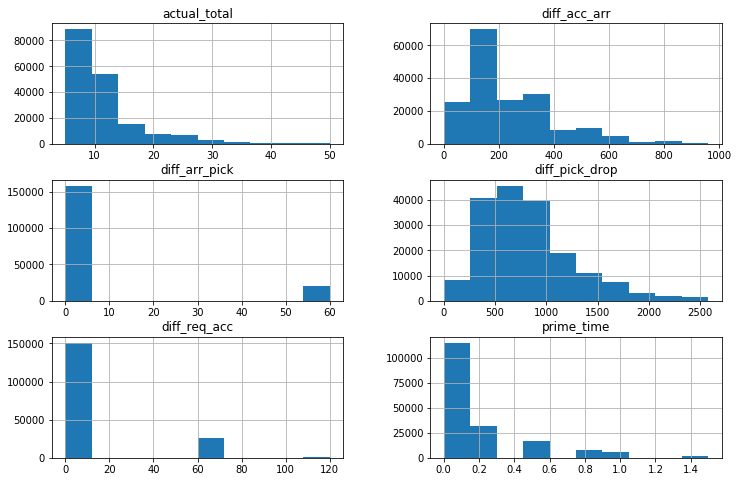

In [1125]:
df3.hist(figsize = (12,8));

## Now It's time to split our data into training and testing sets 

In [1126]:
X = df3[['diff_req_acc','diff_acc_arr','diff_arr_pick','diff_pick_drop','prime_time']]

In [1127]:
y = df3['actual_total']

In [1128]:
from sklearn.model_selection import train_test_split

In [1129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Scaling Our Data
**Given that we don't have normally distributed data, convention tells us 
to use a MinMax Scaler**

In [1130]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [1131]:
from sklearn.linear_model import LinearRegression

In [1132]:
lm = LinearRegression(fit_intercept=False)

In [1133]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [1134]:
lm.coef_

array([ 6.82002515e-01,  4.97853636e+00,  5.31966809e-01,  3.11964180e+01,
       -1.35339995e-03])

In [1135]:
df4 = pd.DataFrame(lm.coef_,X.columns)
df4.columns = ['Coeffecient']

In [1136]:
df4

,Coeffecient
diff_req_acc,0.682003
diff_acc_arr,4.978536
diff_arr_pick,0.531967
diff_pick_drop,31.196418
prime_time,-0.001353


In [1137]:
predictions = lm.predict(X_test)

In [1138]:
dfy = pd.DataFrame(y_test)
dfy.head()

,actual_total
51730,8.70
142116,13.36
23976,5.00
109220,12.14
9917,15.43


In [1139]:
dfy['LCVP'] = predictions
dfy.head()

,actual_total,LCVP
51730,8.70,9.328294
142116,13.36,12.438264
23976,5.00,1.658974
109220,12.14,12.541445
9917,15.43,18.034271


Text(0, 0.5, 'Predicted Y')

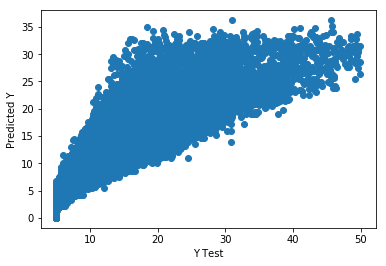

In [1140]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [1141]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 2.13262714695629
MSE: 9.911987957589213
RMSE: 3.1483309796762495


In [1142]:
from sklearn.metrics import r2_score
print(r2_score(y_test,predictions))

0.7297445504367968


In [1143]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [1144]:
ols_model = sm.OLS(y,X).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           actual_total   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                 5.624e+05
Date:                Tue, 24 Sep 2019   Prob (F-statistic):               0.00
Time:                        13:48:24   Log-Likelihood:            -4.5695e+05
No. Observations:              178212   AIC:                         9.139e+05
Df Residuals:                  178207   BIC:                         9.140e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
diff_req_acc       0.0058      0.000     17.902      0.000       0.005       0.006
diff_acc_arr       0.0052   4.13e-05    125.490      0.000       0.005       0.005
diff_arr_pick      0.0091      0.000     23.294      0.000       0.008       0.010
diff_pick_drop     0.0121   1.29e-05    939.987      0.000       0.012       0.012
prime_time        -0.0084      0.026     -0.327      0.744      -0.059       0.042
==============================================================================
Omnibus:                    39602.503   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           225062.459
Skew:                           0.953   Prob(JB):                         0.00
Kurtosis:                       8.165   Cond. No.                     3.29e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1145]:
ols_model.mse_resid

9.877780766954501

In [1146]:
X1 = df3[['diff_req_acc','diff_acc_arr','diff_arr_pick','diff_pick_drop']]
y1 = df3['actual_total']

In [1147]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=101)

In [1148]:
X1_train = scaler.fit_transform(X1_train)
X1_test  = scaler.transform(X1_test)

In [1149]:
ols_model = sm.OLS(y1_train,X1_train).fit()
ols_model.mse_resid

9.863094156709325